## <font style = "color:blue; font-family:ariel"> Mandelbrot Set and timeit analysis </font>

We will draw the set using different methods using plot objects, loops, numpy arrays and numba decorator and see which one takes less time to execute. 

In [1]:
import numpy as np
import matplotlib.pyplot as pp
import matplotlib
import math
%matplotlib inline
import mpld3
%load_ext line_profiler
#%load_ext memory_profiler
import numpy.ma as ma

### <font style = "color:red; font-family:ariel">  Object oriented method: </font>

A plot object is defined and points are added to the object as comuputed. Of course, this is the most computationally expensive method. 

In [2]:
class plot_mad:
    
    def __init__(self, size=(10,10), range=[-2,1,-1.5,1.5]):
        self.fig, self.ax = pp.subplots(figsize=size)
        self.ax.axis(range)
        
    def add_to_plot(self, num, out_n):
        if out_n % 4 == 1:
            col = 'red'
        if out_n % 4 == 2:
            col = 'yellow'
        if out_n % 4 == 3:
            col = 'green'
        if out_n % 4 == 0:
            col = 'blue'
        if out_n ==0:
            col = 'black'
            
        circ = matplotlib.patches.Circle((num.real,num.imag), 
                                         radius=1/720, color=col)
        self.ax.axes.add_patch(circ)
    
    def rescale(self):
        pp.show()
        
    def __enter__(self):
        return self 
    
    def __exit__(self,*kwarg):
        self.rescale()

        
        
def func_evaluator(num, iteration):
    c = num
    is_out = False
    out_n = 0
    for i in range(1,iteration):
        c = c*c+num
        if abs(c)>2:
            is_out = True
            out_n = i
            break
    return is_out, out_n


def Mandel(iteration, plt):
    for r in np.linspace(0,2,200):
        for teta in np.linspace(0,2*math.pi,720):
            num = r*math.cos(teta)+r*math.sin(teta)*1j
            is_out, out_n = func_evaluator(num, iteration)
            if is_out:
                plt.add_to_plot(num, out_n)
            else:
                plt.add_to_plot(num, 0)


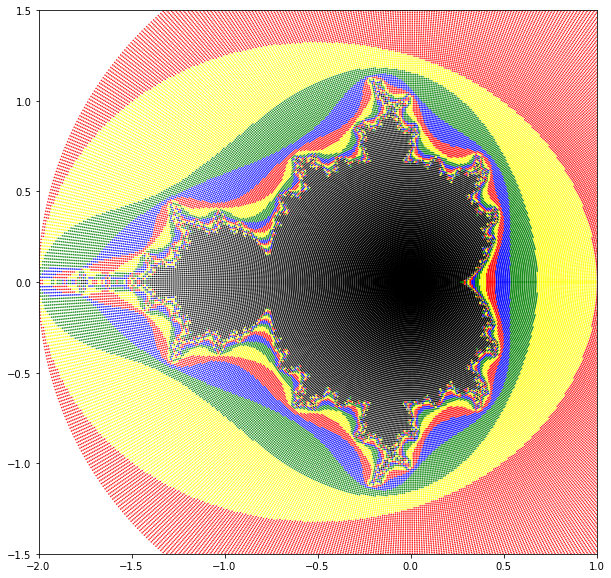

In [3]:
with plot_mad() as pm:
    Mandel(20,pm)

### <font style = "color:orange; font-family:ariel"> Using numpy arrays to plot </font>
Let's put all the points in one array and pass them to the imshow instead of adding to the plot object iteratively. This of course is much faster. 

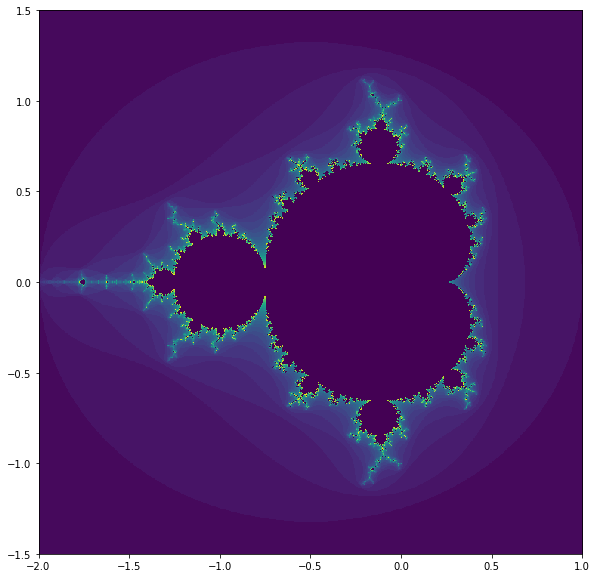

In [4]:
def func_evaluator(num, iteration):
    d=num
    is_out = False
    out_n = 0
    for i in range(1,iteration):
        d = d*d+num
        # if np.absolute(d)>2: very slow
        if abs(d)>2:
            is_out = True
            out_n = i/iteration
            break
    return is_out, out_n


def Mandel(max_iteration=40, resolution=720, ylimit=(-1.5,1.5), xlimit=(-2,1)):
    c = np.zeros((resolution, resolution))
    i = -1
    for y in np.linspace(ylimit[1],ylimit[0],resolution):
        i+=1
        j = -1
        for x in np.linspace(xlimit[0], xlimit[1],resolution):
            j+=1
            num = x+y*1j
            is_out, out_n = func_evaluator(num, max_iteration)
            if is_out:
                c[i,j] = out_n
            else:
                c[i,j] = 0
    return c


mpld3.enable_notebook()
fig, ax = pp.subplots(figsize=(10,10))
pp.imshow(Mandel(max_iteration=40, resolution=720), extent=(-2,1,-1.5,1.5))
pp.show()

### <font color="orange"> Time properties: </font>

In [5]:
%timeit Mandel()

1 loop, best of 3: 2.95 s per loop


In [6]:
%lprun -f Mandel Mandel()

20% of the total time is spent on making the imaginary number and 65% spent on calling the func_evaluator!! Why is this function so time consuming? Can we get rid of this function by shrinking it into the main function? Also, can we get rid of for loop? 

In [7]:
%lprun -f func_evaluator func_evaluator(1+1*1j, 30)

12% in making d=num
16% in range(1,iteration)
38% in abs(d) >2

### <font style="color:green"> Let's get rid of the for loop and bring all the points in a numpy array. Yet, there is still a loop over iterations.

/home/majid/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in multiply
/home/majid/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in multiply
/home/majid/applications/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1032: RuntimeWarning: invalid value encountered in multiply
  masked_da = umath.multiply(m, da)
/home/majid/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: overflow encountered in absolute


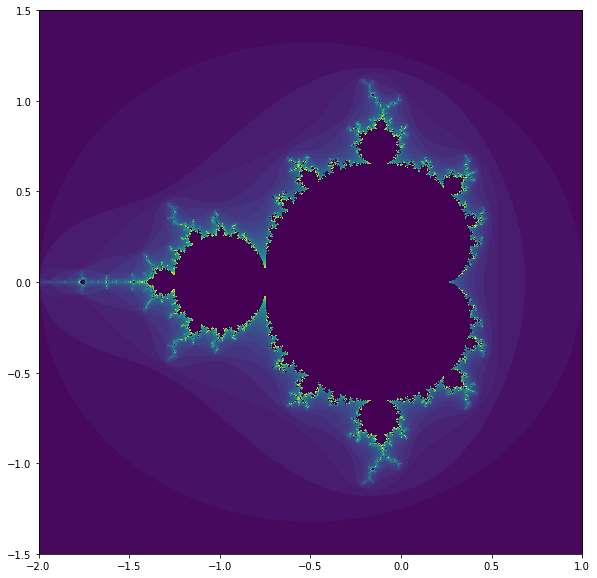

In [8]:
def Mandel_Matx(max_iteration=40, resolution=720, ylimit=(-1.5,1.5), xlimit=(-2,1)):
    c = np.zeros((resolution, resolution))
    i = -1
    x = np.linspace(xlimit[0], xlimit[1],resolution)
    y = np.linspace(ylimit[1],ylimit[0],resolution)
    c = np.zeros(resolution*resolution).reshape(resolution, resolution)
    points = x + 1j*y.reshape(resolution,1)
    points_init = points
    
    for itera_ in np.arange(max_iteration):
        
        points = np.multiply(points, points) + points_init
        
        # masking values > 2
        points_abs = np.abs(points)
        mask_ = ma.masked_greater(points_abs, 2)
        points = np.ma.array(points, mask=mask_.mask)
        mask_c = ma.masked_equal(c, 0)
        mask_total = mask_.mask*mask_c.mask
        c = np.ma.array(c, mask=mask_total, fill_value = (itera_+1)/max_iteration)
        c = c.filled()
        
    return c

mpld3.enable_notebook()
fig, ax = pp.subplots(figsize=(10,10))
pp.imshow(Mandel_Matx(max_iteration=40, resolution=720), extent=(-2,1,-1.5,1.5))
pp.show()

### <font style="font-style:italic;color:green"> Almost 4 times faster than for loop. This is amazing!!! </font>

In [9]:
%timeit Mandel_Matx()

/home/majid/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in multiply
/home/majid/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in multiply
/home/majid/applications/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1032: RuntimeWarning: invalid value encountered in multiply
  masked_da = umath.multiply(m, da)
/home/majid/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: overflow encountered in absolute


1 loop, best of 3: 732 ms per loop


### <font style="color:purple"> numba decorator:</font>

In [10]:
from numba.decorators import autojit

In [11]:
@autojit
def func_evaluator(num, iteration):
    d=num
    is_out = False
    out_n = 0
    for i in range(1,iteration):
        d = d*d+num
        #print(num, c)
        # if np.absolute(d)>2:
        if abs(d)>2:
            is_out = True
            out_n = i/iteration
            break
    return is_out, out_n

@autojit
def Mandel_Numba(max_iteration=40, resolution=720, ylimit=(-1.5,1.5), xlimit=(-2,1)):
    c = np.zeros((resolution, resolution))
    i = -1
    for y in np.linspace(ylimit[1],ylimit[0],resolution):
        i+=1
        j = -1
        for x in np.linspace(xlimit[0], xlimit[1],resolution):
            j+=1
            num = x+y*1j
            is_out, out_n = func_evaluator(num, max_iteration)
            if is_out:
                c[i,j] = out_n
            else:
                c[i,j] = 0
    return c

### <font style="color:purple"> This was really fast. Almost 14 times faster than the numpy array method.</font>

In [12]:
%timeit Mandel_Numba()

The slowest run took 5.72 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 53.1 ms per loop


## Summary:

- #### slowest method was when we defined a plot objects and added points to it on each iteration. 

- #### It became much faster when we handed all the points in an array to the plot. But, due to the iterations over points, it was still slow. 

- #### It became really fast when all the matrix operations and substitutions was done in numpy 2D arrays.

- #### When the loops are unavoidable, numba decorator greatly helped is reducing execution time